In [1]:
import warnings
import zipfile
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import umap.umap_ as umap
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

d:\GitHub\itmo_recsys\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_and_extract() -> None:
    url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
    filename = Path('kion_train.zip')
    data_dir = Path('data_original')

    if data_dir.exists():
        return

    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as f:
        total = int(response.headers.get('content-length', 0))
        for chunk in tqdm(
            response.iter_content(1024 * 1024),
            desc=f'Downloading {filename.name}',
            total=total // (1024 * 1024),
            unit='MB',
        ):
            f.write(chunk)

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

    filename.unlink()


download_and_extract()


In [3]:
interactions_df = pd.read_csv('data_original/interactions.csv')
users_df = pd.read_csv('data_original/users.csv')
items_df = pd.read_csv('data_original/items.csv')

interactions_df.shape, users_df.shape, items_df.shape

((5476251, 5), (840197, 5), (15963, 14))

In [4]:
user_cat_feats = ['age', 'income', 'sex', 'kids_flg']

users_ohe_df = users_df['user_id']
for feat in user_cat_feats:
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

print('Размер users_df после one-hot-encoding фичей:', users_ohe_df.shape)
users_ohe_df.tail()

Размер users_df после one-hot-encoding фичей: (840197, 17)


,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
840192,339025,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,False
840193,983617,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True
840194,251008,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
840195,590706,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
840196,166555,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False


In [5]:
item_cat_feats = [
    'content_type',
    'release_year',
    'for_kids',
    'age_rating',
    'studios',
    'countries',
    'directors',
]

items_ohe_df = items_df['item_id']

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1)

print('Размер items_df после one-hot-encoding фичей:', items_ohe_df.shape)
items_ohe_df.tail()

Размер items_df после one-hot-encoding фичей: (15963, 8814)


,item_id,content_type_film,content_type_series,release_year_1897.0,release_year_1916.0,release_year_1917.0,release_year_1918.0,release_year_1920.0,release_year_1921.0,release_year_1922.0,...,directors_Яннике Систад Якобсен,directors_Янус Мец,directors_Ярив Хоровиц,directors_Ярон Зильберман,directors_Ярополк Лапшин,directors_Ярослав Лупий,"directors_Ярроу Чейни, Скотт Моужер",directors_Ясина Сезар,directors_Ясуоми Умэцу,directors_сения Завьялова
15958,6443,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15959,2367,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15960,10632,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15961,4538,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15962,3206,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# тут не менял минимальное число взаимодействий, но было бы интересно посмотреть,
# как это влияет на качество модели
interactions_df = interactions_df[interactions_df['watched_pct'] > 10]

valid_users = interactions_df['user_id'].value_counts()[lambda x: x > 10].index
valid_items = interactions_df['item_id'].value_counts()[lambda x: x > 10].index

interactions_df = interactions_df[
    interactions_df['user_id'].isin(valid_users)
    & interactions_df['item_id'].isin(valid_items)
]

print(f'Пользователей после фильтрации: {interactions_df["user_id"].nunique()}')
print(f'Айтемов после фильтрации: {interactions_df["item_id"].nunique()}')

Пользователей после фильтрации: 79515
Айтемов после фильтрации: 6901


In [7]:
interactions_df = interactions_df[
    interactions_df['item_id'].isin(items_ohe_df['item_id'].unique())
    & interactions_df['user_id'].isin(users_ohe_df['user_id'].unique())
]

items_ohe_df = items_ohe_df[
    items_ohe_df['item_id'].isin(interactions_df['item_id'].unique())
]
users_ohe_df = users_ohe_df[
    users_ohe_df['user_id'].isin(interactions_df['user_id'].unique())
]

interactions_df['uid'], _ = pd.factorize(interactions_df['user_id'])
interactions_df['iid'], _ = pd.factorize(interactions_df['item_id'])

print(f'Взаимодействий после фильтрации: {interactions_df.shape}')
interactions_df.tail()

Взаимодействий после фильтрации: (1463641, 7)


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
5476218,840031,429,2021-04-10,7307,100.0,32080,760
5476224,663351,2301,2021-07-25,9337,100.0,29466,30
5476226,435089,13475,2021-07-06,4624,85.0,9748,1474
5476239,610017,7107,2021-05-10,1133,75.0,50987,68
5476249,384202,16197,2021-04-19,6203,100.0,35303,768


In [8]:
interactions_vec = np.zeros(
    (interactions_df['uid'].nunique(), interactions_df['iid'].nunique())
)
np.add.at(interactions_vec, (interactions_df['uid'], interactions_df['iid']), 1)

interactions_vec /= interactions_vec.sum(axis=1, keepdims=True)

iid_to_item_id = (
    interactions_df.drop_duplicates('iid').set_index('iid')['item_id'].to_dict()
)
item_id_to_iid = (
    interactions_df.drop_duplicates('item_id').set_index('item_id')['iid'].to_dict()
)

uid_to_user_id = (
    interactions_df.drop_duplicates('uid').set_index('uid')['user_id'].to_dict()
)
user_id_to_uid = (
    interactions_df.drop_duplicates('user_id').set_index('user_id')['uid'].to_dict()
)

items_ohe_df['iid'] = items_ohe_df['item_id'].map(item_id_to_iid)
items_ohe_df = items_ohe_df.set_index('iid')

users_ohe_df['uid'] = users_ohe_df['user_id'].map(user_id_to_uid)
users_ohe_df = users_ohe_df.set_index('uid')

In [9]:
N_FACTORS = 128

ITEM_MODEL_SHAPE = items_ohe_df.drop('item_id', axis=1).shape[1]
USER_META_MODEL_SHAPE = users_ohe_df.drop('user_id', axis=1).shape[1]

USER_INTERACTION_MODEL_SHAPE = interactions_vec.shape[1]

print(f'N_FACTORS: {N_FACTORS}')
print(f'ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}')
print(f'USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}')
print(f'USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}')

N_FACTORS: 128
ITEM_MODEL_SHAPE: 8813
USER_META_MODEL_SHAPE: 16
USER_INTERACTION_MODEL_SHAPE: 6897


In [10]:
class ItemModel(nn.Module):
    def __init__(self, n_factors=128):
        super(ItemModel, self).__init__()

        # добавил DropOut и BatchNorm для регуляризации
        self.model = nn.Sequential(
            nn.Linear(ITEM_MODEL_SHAPE, n_factors),
            nn.BatchNorm1d(n_factors),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(n_factors, n_factors),
            nn.BatchNorm1d(n_factors),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(n_factors, n_factors),
        )

    def forward(self, x):
        return self.model(x)


class UserModel(nn.Module):
    def __init__(self, n_factors=128):
        super(UserModel, self).__init__()

        # добавил DropOut и BatchNorm для регуляризации
        self.meta_branch = nn.Sequential(
            nn.Linear(USER_META_MODEL_SHAPE, n_factors),
            nn.BatchNorm1d(n_factors),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(n_factors, n_factors),
            nn.BatchNorm1d(n_factors),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        self.interaction_branch = nn.Sequential(
            nn.Linear(USER_INTERACTION_MODEL_SHAPE, n_factors),
            nn.BatchNorm1d(n_factors),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        self.combined = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta_out = self.meta_branch(meta)
        inter_out = self.interaction_branch(interaction)
        x = torch.cat([meta_out, inter_out], dim=1)
        return self.combined(x)

In [11]:
pos_dists_all = []
neg_dists_all = []


# этот loss не используется, остался просто для сравнения было -> сделал
def triplet_loss(anchor, positive, negative, margin=0.4) -> torch.tensor:
    pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
    neg_dist = torch.sum((anchor - negative) ** 2, dim=1)

    pos_dists_all.extend(pos_dist.detach().cpu().numpy())
    neg_dists_all.extend(neg_dist.detach().cpu().numpy())

    return F.relu(pos_dist - neg_dist + margin).mean()


def soft_margin_triplet_loss(anchor, positive, negative) -> torch.tensor:
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)

    pos_dists_all.extend(pos_dist.detach().cpu().numpy())
    neg_dists_all.extend(neg_dist.detach().cpu().numpy())

    return torch.log(1 + torch.exp(pos_dist - neg_dist)).mean()


class RecSysDataset(Dataset):
    def __init__(self, items, users, interactions):
        self.items = items
        self.users = users
        self.interactions = interactions

    def __len__(self):
        return self.interactions.shape[0]

    def __getitem__(self, idx):
        uid = idx
        pos_i = np.random.choice(
            range(self.interactions.shape[1]), p=self.interactions[uid]
        )
        neg_i = np.random.choice(
            np.delete(np.arange(self.interactions.shape[1]), pos_i)
        )  # исключаю pos_i, чтобы случайно не выбрали положительный пример

        uid_meta = self.users.iloc[uid].values
        uid_interaction = self.interactions[uid]
        pos = self.items.iloc[pos_i].values
        neg = self.items.iloc[neg_i].values

        return (
            torch.tensor(uid_meta, dtype=torch.float32),
            torch.tensor(uid_interaction, dtype=torch.float32),
            torch.tensor(pos, dtype=torch.float32),
            torch.tensor(neg, dtype=torch.float32),
        )

In [12]:
i2v = ItemModel()
u2v = UserModel()
optimizer = optim.Adam(list(i2v.parameters()) + list(u2v.parameters()), lr=0.001)
dataset = RecSysDataset(
    items=items_ohe_df.drop('item_id', axis=1),
    users=users_ohe_df.drop('user_id', axis=1),
    interactions=interactions_vec,
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
EPOCHS = 2

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        uid_meta, uid_interaction, pos, neg = batch
        optimizer.zero_grad()
        anchor = u2v(uid_meta, uid_interaction)
        positive = i2v(pos)
        negative = i2v(neg)
        loss = soft_margin_triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        if num_batches % 50 == 0:
            print(f'Epoch {epoch + 1}, Batch {num_batches}, Loss: {loss.item()}')

    avg_epoch_loss = epoch_loss / num_batches
    print(f'Epoch {epoch + 1} finished, Average Loss: {avg_epoch_loss:.4f}')


Epoch 1, Batch 50, Loss: 0.6490259170532227
Epoch 1, Batch 100, Loss: 0.5529587268829346
Epoch 1, Batch 150, Loss: 0.2646934390068054
Epoch 1, Batch 200, Loss: 0.149129256606102
Epoch 1, Batch 250, Loss: 0.09464842081069946
Epoch 1, Batch 300, Loss: 0.03605528920888901
Epoch 1, Batch 350, Loss: 0.011965831741690636
Epoch 1, Batch 400, Loss: 0.014498496428132057
Epoch 1, Batch 450, Loss: 0.012952882796525955
Epoch 1, Batch 500, Loss: 0.14266636967658997
Epoch 1, Batch 550, Loss: 0.004687744192779064
Epoch 1, Batch 600, Loss: 0.0059055001474916935
Epoch 1, Batch 650, Loss: 0.0022665534634143114
Epoch 1, Batch 700, Loss: 0.0038317819125950336
Epoch 1, Batch 750, Loss: 0.0036692507565021515
Epoch 1, Batch 800, Loss: 0.0006041330052539706
Epoch 1, Batch 850, Loss: 0.03630536049604416
Epoch 1, Batch 900, Loss: 0.0019580908119678497
Epoch 1, Batch 950, Loss: 0.0010014174040406942
Epoch 1, Batch 1000, Loss: 0.002201816765591502
Epoch 1 finished, Average Loss: 0.1179
Epoch 2, Batch 50, Loss: 0.

In [14]:
u2v.eval()
i2v.eval()

users_meta_feats = torch.tensor(
    users_ohe_df.drop('user_id', axis=1).values, dtype=torch.float32
)
users_interaction_vec = torch.tensor(interactions_vec, dtype=torch.float32)
items_feats = torch.tensor(
    items_ohe_df.drop('item_id', axis=1).values, dtype=torch.float32
)

users_vec = u2v(users_meta_feats, users_interaction_vec)
items_vecs = i2v(items_feats)

dists = torch.cdist(users_vec, items_vecs)
top10_iids = torch.argsort(dists, dim=1)[:, :10]

top10_iids_item = [iid_to_item_id[iid.item()] for iid in top10_iids.reshape(-1)]
top10_iids_item = np.array(top10_iids_item).reshape(top10_iids.shape)

df_dssm = pd.DataFrame(
    {'user_id': [uid_to_user_id[uid] for uid in np.arange(top10_iids_item.shape[0])]}
)
df_dssm['item_id'] = list(top10_iids_item)
df_dssm = df_dssm.explode('item_id')
df_dssm['rank'] = df_dssm.groupby('user_id').cumcount() + 1
df_dssm = df_dssm.groupby('user_id').agg({'item_id': list}).reset_index()

# сохраняю только предсказания, т.к. не очень хочу внедрять модели в сервис
df_dssm.to_pickle('../../models/dssm_model_with_popular_df.pickle')
df_dssm.tail()

,user_id,item_id
65969,1097486,"[3734, 13865, 11237, 15297, 10910, 1998, 6649,..."
65970,1097489,"[4457, 3734, 12995, 15297, 101, 13865, 1998, 1..."
65971,1097508,"[4457, 3734, 15297, 13865, 10440, 11237, 12995..."
65972,1097513,"[4457, 3734, 12995, 15297, 101, 14636, 16166, ..."
65973,1097516,"[4457, 3734, 15297, 13865, 10440, 12995, 11237..."


In [15]:
true_interactions = defaultdict(set)

for uid, group in interactions_df.groupby('user_id'):
    items = group.sort_values('watched_pct', ascending=False)['item_id'].tolist()
    true_interactions[uid] = set(items[:10])

precision_list = []
recall_list = []

for _, row in df_dssm.iterrows():
    predicted_items = set(row['item_id'])
    true_items = true_interactions.get(row['user_id'], set())

    if not true_items:
        continue

    true_positives = len(predicted_items & true_items)
    precision_list.append(true_positives / len(predicted_items))
    recall_list.append(true_positives / len(true_items))

print(f'Precision@10: {np.mean(precision_list):.4f}')
print(f'Recall@10: {np.mean(recall_list):.4f}')


Precision@10: 0.0865
Recall@10: 0.0865


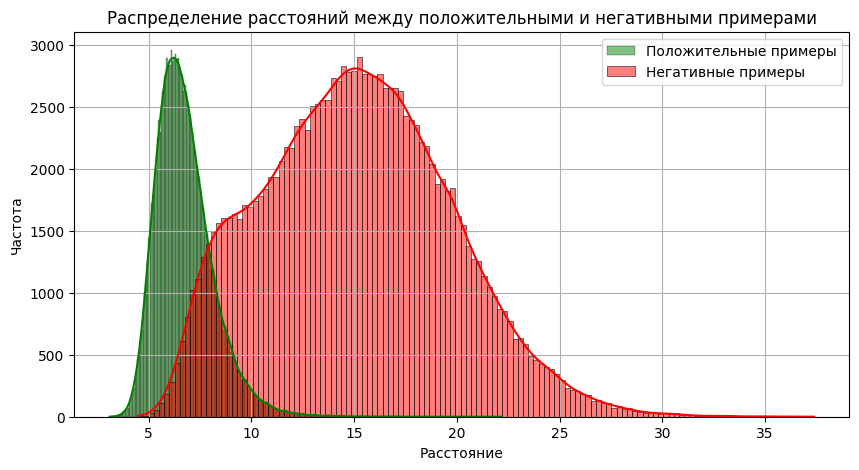

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(pos_dists_all, label='Положительные примеры', color='green', kde=True)
sns.histplot(neg_dists_all, label='Негативные примеры', color='red', kde=True)
plt.title('Распределение расстояний между положительными и негативными примерами')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()

# ожидаемо, распределение расстояний до негативных примеров чуть дальше (уверен,
# что это статзначимо), все же модель чему-то да научилась. к тому же измененный
# loss не зануляет ошибку, если расстояние до положительного примера меньше

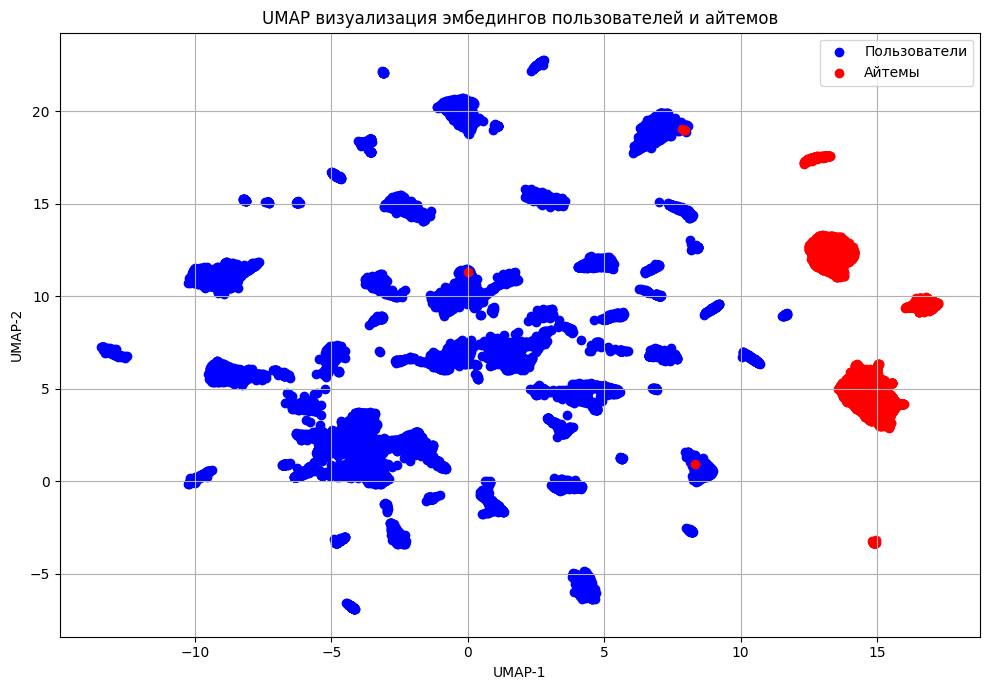

In [17]:
users_meta_feats = torch.tensor(
    users_ohe_df.drop('user_id', axis=1).values, dtype=torch.float32
)
users_interaction_vec = torch.tensor(interactions_vec, dtype=torch.float32)
items_feats = torch.tensor(
    items_ohe_df.drop('item_id', axis=1).values, dtype=torch.float32
)

with torch.no_grad():
    user_embeddings = u2v(users_meta_feats, users_interaction_vec).numpy()
    item_embeddings = i2v(items_feats).numpy()

combined_embeddings = np.concatenate([user_embeddings, item_embeddings], axis=0)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
reduced = umap_reducer.fit_transform(combined_embeddings)

n_users = user_embeddings.shape[0]

plt.figure(figsize=(10, 7))
plt.scatter(reduced[:n_users, 0], reduced[:n_users, 1], c='blue', label='Пользователи')
plt.scatter(reduced[n_users:, 0], reduced[n_users:, 1], c='red', label='Айтемы')
plt.legend()
plt.title('UMAP визуализация эмбедингов пользователей и айтемов')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.tight_layout()
plt.show()

# по-хорошему бы отделить айтемы и пользователей на разные картинки. но даже так
# видно, что эмбединги модели выделили несколько кластеров, видимо по жанру
# контента или по предпочтениям пользователей

в ходе работы, последовательно добавлял улучшения в порядке роста их сложности:

0. "причесал" код на свой вкус, функционально ничего не изменив. суть baseline

1. добавил DropOut и BatchNorm в обе модели впритык к линейным слоям

2. заменил triplet_loss на soft_margin_triplet_loss, чтобы не занулять ошибку

3. добавил расчет precision@10 и recall@10, чтобы посчитать табличку ниже

4. визуализировал распределение расстояний до положительного и негативного примеров

5. с помощью UMAP визуализировал кластеры эмбедингов пользователей и айтемов

метрики после каждого изменения в модели, где доработки учитываю накопительно:

| эксперимент           | avg loss | precision@10 | recall@10 |
|-----------------------|----------|--------------|-----------|
| baseline              | 0.1323   | 0.1317       | 0.1317    |
| + Dropout и BatchNorm | 0.0378   | 0.0259       | 0.0259    |
| + soft_margin_loss    | 0.0066   | 0.0865       | 0.0865    |

важно помнить, что нейросети - очень гибкие и тонкие в настройке, поэтому avg loss
от раза к разу может неплохо скакать даже без изменений. я это особо не контролирую
и не беру во внимание, насколько полученные рекомендации пересекаются с популярными,
а надо бы... однако заметил, что частенько первые 2 айтема - 10440 и 9728, которые
как раз являются топ-1 и топ-3 по популярности соответственно. в общем, исследовать
здесь можно еще много и долго